In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/personal project/Online Retail.xlsx'
df = pd.read_excel(file_path)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#check if there are missing values
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


# Missing Items

### **CustomerID**
- guest checkout
- in-store or anonymous purchases
- incomplete records

Even though there are transactions with missing CustomerID that doesn't mead that the transaction is invalid. It most likely represent anonymous or guest purchases. They are valid, but it limits customer-level analysis since we don't know who purchased what.

### **Description**
- Old or discontinued products
- system import issues

Some values are missing for description, but it doesn't affect the analysis because description doesn't have impact on revenue.

In [4]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [5]:
#Data Cleaning

df_customer = df.dropna(subset = ['CustomerID']).copy()

df_customer['CustomerID'] = df_customer['CustomerID'].astype(int)

df_customer.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
Revenue,0


In [6]:
#Sanity Check
df_customer.shape

(406829, 9)

# Goal of the Analysis

From this analysis I'm trying to identify Revenue concentration by customers and Revenue concentration by products. These will be a helpful indicator when looking into business risk and marketing focus, because we will know what to target when making business decisions. If small number of customers generate most revenue we can prioritize them when making decisions and if certain item is driving most sales then when restocking the inventory we can order more of those items.

In [7]:
#Revenue concentration by customers

df_customer['Revenue'] = df_customer['Quantity'] * df_customer['UnitPrice']

customer_revenue = (df_customer.groupby('CustomerID')['Revenue'].sum().sort_values(ascending = False))

In [8]:
type(customer_revenue)
customer_revenue.shape
customer_revenue.head()

,Revenue
CustomerID,
14646,279489.02
18102,256438.49
17450,187482.17
14911,132572.62
12415,123725.45


In [9]:
#Computing concentration metrics

total_revenue  = customer_revenue.sum()
n_customers = len(customer_revenue)

for p in [0.01, 0.05, 0.10]:
  cutoff = int(n_customers * p)
  share = customer_revenue.iloc[:cutoff].sum() / total_revenue
  print(f"Top {int(p * 100)}% customers: {share:.2%} of revenue")

Top 1% customers: 29.71% of revenue
Top 5% customers: 48.52% of revenue
Top 10% customers: 60.01% of revenue


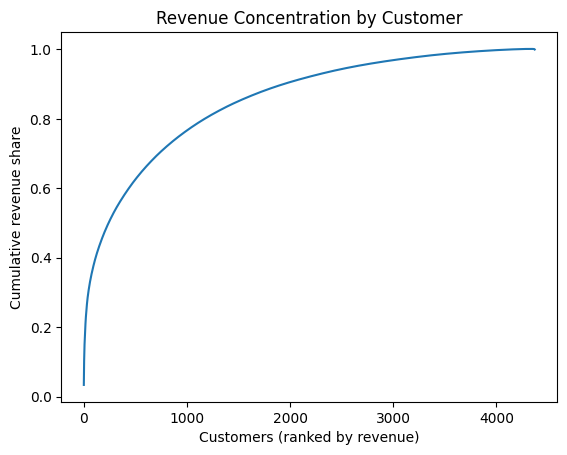

In [10]:
import matplotlib.pyplot as plt

cumulative_share = customer_revenue.cumsum() / total_revenue

plt.figure()
plt.plot(cumulative_share.values)
plt.xlabel("Customers (ranked by revenue)")
plt.ylabel("Cumulative revenue share")
plt.title("Revenue Concentration by Customer")
plt.show()

### Graph Interpretation

The curve rises very steeply at first, but levels out quickly creating a curve that looks logarithmic. More specifically, it tells that small number of customers generate a large share of revenue through the steep rise, while most customers contribute very little as shown by the flatten out curve. Furthermore, this indicates a power-law distribution and revenue concentration risk.

Since the company is highly dependent on a small subset of customers, losing few top customers would result in a huge decline in their revenue.

# Revenue Concentration Over Time

In this section I want to address if the business is becoming more dependent on top customers over time or not.

In [13]:
df_customer['Month'] = df_customer['InvoiceDate'].dt.to_period('M')

def top_share_by_month(df, top_pct = 0.05):
  shares = []

  for month, g in df.groupby('Month'):
    customer_rev = (
        g.groupby('CustomerID')['Revenue']
        .sum().sort_values(ascending = False)
    )
    n = len(customer_rev)
    cutoff = max(1, int(n * top_pct))

    share = customer_rev.iloc[:cutoff].sum() / customer_rev.sum()
    shares.append((month.to_timestamp(), share))

  return pd.DataFrame(shares, columns = ['Month', 'TopShare'])

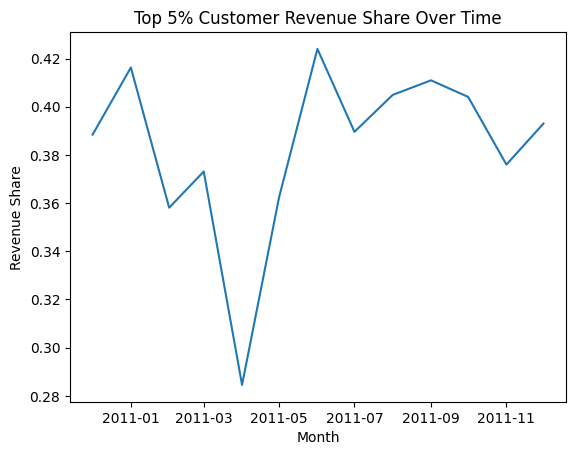

In [14]:
top5 = top_share_by_month(df_customer, 0.05)

plt.figure()
plt.plot(top5['Month'], top5['TopShare'])
plt.title('Top 5% Customer Revenue Share Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue Share')
plt.show()

### Graph Interpretation

The graph shows what % of total revenue comes from the top 5% of customers. Based on the graph the range is around 28% to 43%. This shows that even at its lowest almost 28% is coming from the top 5% of customers showing that small group of customers drives a large chunk of revenue. Furthermore, at its highest almost half of the revenue comes from only that 5% of customers. Therefore, it shows high concentration , but there are no clear patterns that can be noticed from the graph. Therefore, the business is not becoming more dependent on top customers, but it is still true that the top customers are still drives most of their revenue. Thus, the business is persistently depending on high-value customers.

In [15]:
#Churn Scenarios

for p in [0.01, 0.05, 0.10]:
  cutoff = int(n_customers * p)
  lost_revenue = customer_revenue.iloc[:cutoff].sum()
  loss_pct = lost_revenue / total_revenue

  print(f"If top {int(p*100)}% churn --> lose {loss_pct:.1%} of revenue")

If top 1% churn --> lose 29.7% of revenue
If top 5% churn --> lose 48.5% of revenue
If top 10% churn --> lose 60.0% of revenue


###Interpretation

The churn scenarios shows that if the business lose their top 5% customers, half of their revenue would be gone. This tells that the business is highly vulnerable to churn among high-value customers.

In [17]:
#Revenue Concentration by Products
product_revenue = (
    df_customer.groupby('StockCode')['Revenue']
    .sum().sort_values(ascending = False)
)

total_revenue = product_revenue.sum()
n_products = len(product_revenue)

for p in [0.01, 0.05, 0.10]:
  cutoff = max(1, int(n_products * p))
  share = product_revenue.iloc[:cutoff].sum() / total_revenue
  print(f"Top {int(p*100)}% products: {share:.2%} of revenue")

Top 1% products: 17.36% of revenue
Top 5% products: 44.20% of revenue
Top 10% products: 60.70% of revenue


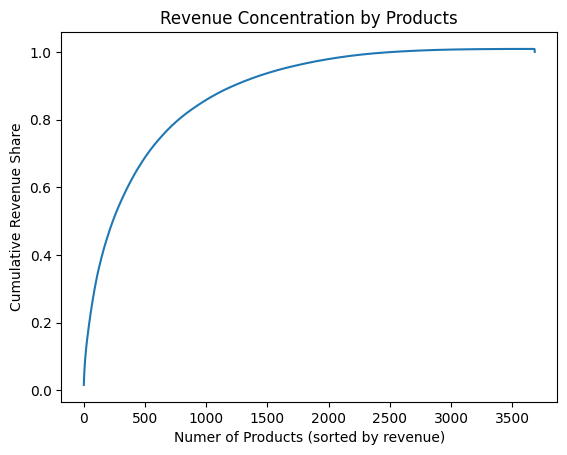

In [18]:
#Visualization

cum_revenue_share = product_revenue.cumsum() / total_revenue
cum_products = range(1, len(cum_revenue_share) + 1)

plt.figure()
plt.plot(cum_products, cum_revenue_share)
plt.xlabel("Numer of Products (sorted by revenue)")
plt.ylabel("Cumulative Revenue Share")
plt.title("Revenue Concentration by Products")
plt.show()

###Graph Interpretation

Similar to revenue concentration by customers, revenue concentration by products also shows steep increase in the beginning as the graph flattens out later. This shows that the business is depending on small amount of products for their total revenue which indicates high product concentration risk.

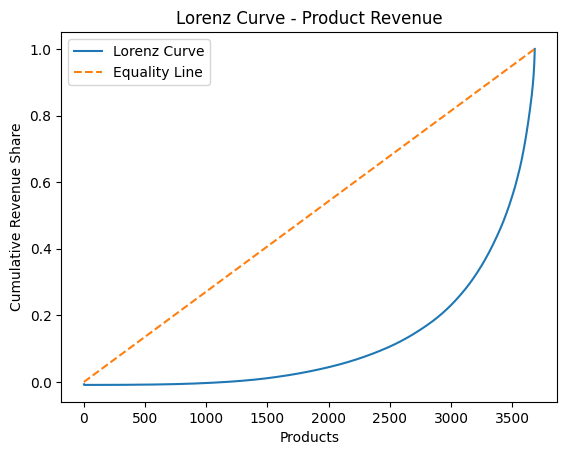

In [20]:
#Lorenz Curve for Products

sorted_rev = product_revenue.sort_values()
cum_rev = sorted_rev.cumsum() / total_revenue
cum_prod = range(1, len(cum_rev) + 1)

plt.figure()
plt.plot(cum_prod, cum_rev, label = "Lorenz Curve")
plt.plot([0, len(cum_rev)], [0, 1], linestyle='--', label  = "Equality Line")
plt.xlabel("Products")
plt.ylabel("Cumulative Revenue Share")
plt.legend()
plt.title("Lorenz Curve - Product Revenue")
plt.show()

### Graph Interpretation

Lorenz Curve is used to visualize how concentrated revenue is by comparing the cumulative share of products or customers to cumulative revenue. The graph shows that revenue is highly concentrated among small subset of products. This is due to the Lorenz curve being far below the equality line. The top 5% of products account for a disproportionately large share of total revenue, which is almost 50%. This indicates high reliance on a limited number of high-performing items. Therefore, it suggests potential risk if demand for that products declines, but also shows opportunities to invest in inventory planning, marketing, and product diversification.

# Conclusion
This analysis shows that the retail business shows high revenue concentration, witha a relatively small percentage of customers and products being responsible for a disproportionately large share of total revenue. While this can be beneficial in short term by maximizing revenue, it also introduces risk, as changes in behavior among these key customers or decline in demands for top products could significantly impact overall revenue.

To improve long-term stability and growth, the retailer should work on dversifying revenue sources. Furthermore, on the customer side, they can utilize target retention strategies for high-value custoemrs, while investing in loyalty programs and personalized promotions to increasing spending among mid-tier and new customers. Reducing over-reliance on a small group of customers would make revenue more resilient to churn.

From a product perspective, the business can use insights from product revenue concentration to inform inventory and marketing decisions. Best-selling products should be managed so that they can avoid stockouts, while underperfoming products with potential can be supported through targeted marketing, pricing experiemnts, and other strategies.

In conclusion, by combining customer-focused retention efforts with product portfolio diversification, the retailer can reduce revenue concentration risk while building a more balanced and sustainable business model.